In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.ticker import FormatStrFormatter
#if needed: ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
%matplotlib inline 

In [3]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [4]:
# uncertainty for both MLL and Scikit are now sqrt(counts), but implemented differently (std dev versus rand err method in scikit)
# nuc and act trainsets use flat 1% unc/rand err
# 100% of the train set is tested (implemented differently: cv=5 for scikit and LOOV for MLL)

In [4]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/processed_results/'

# Error Bar Plots

In [5]:
x = ['Nuc29', 'Act32', 'Act7/12', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
d_x = [-0.2, 0, 0.2]
ens = ['_auto', '_short', '_long']
en_lbl = ['Auto', 'Short', 'Long']
algs = ['knn', 'dtree', 'mll']
alg_lbl = ['kNN', 'Dec Tree', 'MLL Calc']
c_ens = ['M', 'M', 'M']
c_algs = ['L', 'M', 'D']
c = ['Brwn', 'Teal', 'Purp']
mets = {'MAE' : 'Neg MAE', 
        'MedAE' : 'Neg MedAE', 
        'MAPE' : 'Neg MAPE', 
        'Acc' : 'Accuracy',
        'BalAcc' : 'Balanced Accuracy'}
err = {'MAE' : 'MAE Std', 
       'MAPE' : 'MAPE Std', 
       'Acc' : 'Acc CI',
       'BalAcc' : 'BalAcc CI'}

In [7]:
#df = pd.read_pickle(rdrive + 'burnup_detectors_mll_scikit_compare_MedAE.pkl')
#df

In [6]:
#x = np.array(X, dtype=float)
def plot_by_enlist(a, ax, fig, df, metric):
    ax.set_title(en_lbl[a]+' Energy Windows List', fontsize=16)
    for i in range(0,3):
        y = df.loc[:, (algs[i]+ens[a], mets[metric])]
        if metric == 'MedAE':
            yerr = [df.loc[:, (algs[i]+ens[a], 'IQR_25')], df.loc[:, (algs[i]+ens[a], 'IQR_75')]]
        else:
            yerr = df.loc[:, (algs[i]+ens[a], err[metric])]
        trans = Affine2D().translate(d_x[i], 0.0) + ax.transData
        _, _, bars = ax.errorbar(x, y, yerr=yerr, transform=trans, color=colors[c_ens[i]+c[i]], marker='o', linestyle='None', mew=0, ms=9, elinewidth=3, alpha=0.9, label=alg_lbl[i])
        [bar.set_alpha(0.4) for bar in bars]
    ax.legend(loc='lower center', title='Algorithm', ncol=3)
    for i, det in enumerate(x):
        if i % 2 == 0:
            a = 0.0
        else:
            a = 0.15
        ax.axvspan(i-0.5, i+0.5, alpha=a, color='grey')
    return fig

def plot_by_alg(a, ax, fig, df, metric):
    ax.set_title(alg_lbl[a], fontsize=16)
    for i in range(0,3):
        y = df.loc[:, (algs[a]+ens[i], mets[metric])]
        if metric == 'MedAE':
            yerr = [df.loc[:, (algs[a]+ens[i], 'IQR_25')], df.loc[:, (algs[a]+ens[i], 'IQR_75')]]
        else:
            yerr = df.loc[:, (algs[a]+ens[i], err[metric])]
        trans = Affine2D().translate(d_x[i], 0.0) + ax.transData
        _, _, bars = ax.errorbar(x, y, yerr=yerr, transform=trans, color=colors[c_algs[i]+c[a]], marker='o', linestyle='None', mew=0, ms=9, elinewidth=3, alpha=0.9, label=en_lbl[i])
        [bar.set_alpha(0.4) for bar in bars]
    ax.legend(loc='lower center', title='Energy Windows', ncol=3)
    return fig

In [8]:
def plot(pred_param, title, plttype, metric, pred_min):
    
    df = pd.read_pickle(rdrive + pred_param +'_detectors_mll_scikit_compare_' + metric + '.pkl')
    
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,5))
    
    axlbls = {'MAE' : 'Negative MAE', 
              'MedAE' : 'Negative MedAE', 
              'MAPE' : 'Negative MAPE [%]',
              'Acc' : 'Accuracy Score',
              'BalAcc' : 'Balanced Accuracy Score'}
    sv_base = './plots/detector_preds_wrt_' + plttype + '_'
    if 'Burnup' in title:
        axlbl = axlbls[metric] + ' [MWd/MTU]'
        sv_fig = sv_base + metric + '_burn.png'
    elif 'Reactor' in title:
        axlbl = axlbls[metric]
        sv_fig = sv_base + metric + '_rxtr.png'
    elif 'Enrichment' in title:
        axlbl = axlbls[metric] + ' [% $^{235}$U]'
        sv_fig = sv_base + metric + '_enri.png'
    else:
        axlbl = axlbls[metric] + ' [days]'
        sv_fig = sv_base + metric + '_cool.png'
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    axs[0].set_ylabel(axlbl, fontsize=20, labelpad=15)
    
    for a, ax in enumerate(axs):
        if plttype == 'enlist':
            plot_by_enlist(a, ax, fig, df, metric)
        else:
            plot_by_alg(a, ax, fig, df, metric)
        ax.tick_params(labelsize=14, labelrotation=45)
        hcolor = ['tab:red', 'tab:gray']
        for w, pmin in enumerate(pred_min):
            ax.axhline(y=pmin, color=hcolor[w], linestyle='-', linewidth=2)
    #fig.suptitle(title, fontsize=22)
    #fig.subplots_adjust(top=.85)
    plt.subplots_adjust(wspace=0.05)
    
    return fig, axs, sv_fig

<Figure size 432x288 with 0 Axes>

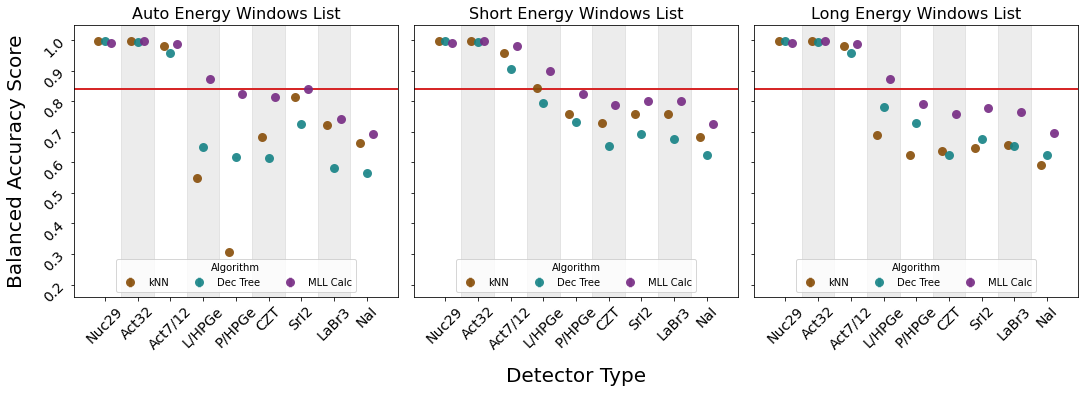

In [10]:
rxtr_min = [0.75]
#fig, axs, sv_fig = plot('reactor', 'Reactor Type Prediction, Accuracy Score', 'enlist', 'Acc', rxtr_min)
#axs[0].set_ylim(None, 1.15)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

rxtr_min = [0.84]
fig, axs, sv_fig = plot('reactor', 'Reactor Type Prediction, Balanced Accuracy Score', 'enlist', 'BalAcc', rxtr_min)
axs[0].set_ylim(0.16, 1.05)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

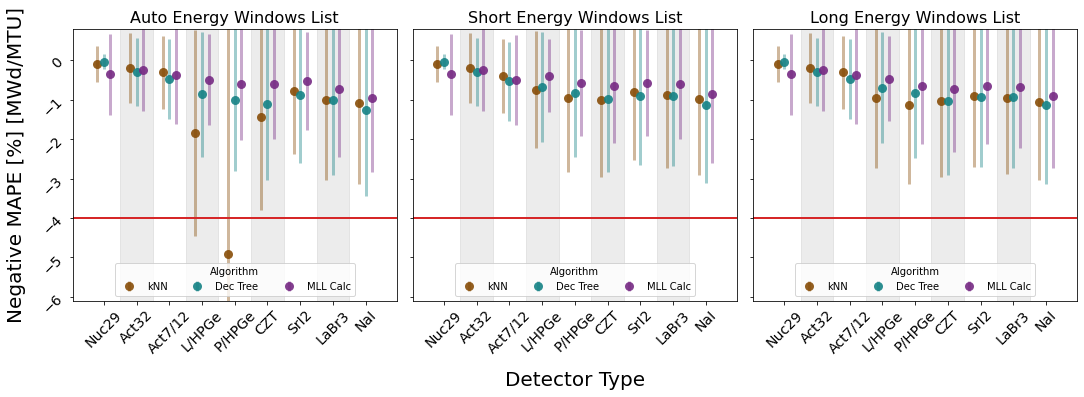

In [11]:
burn_min = [-1000]
#fig, axs, sv_fig = plot('burnup', 'Burnup Prediction, Mean Absolute Error', 'enlist', 'MAE', burn_min)
#axs[0].set_ylim(-1700, 99)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

#burn_min = [-200, -20]
#fig, axs, sv_fig = plot('burnup', 'Burnup Prediction, Median Absolute Error', 'enlist', 'MedAE', burn_min)
#axs[0].set_ylim(-715, 49)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

burn_min = [-4]
fig, axs, sv_fig = plot('burnup', 'Burnup Prediction, Mean Absolute Percentage Error', 'enlist', 'MAPE', burn_min)
axs[0].set_ylim(-6.1, 0.8)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

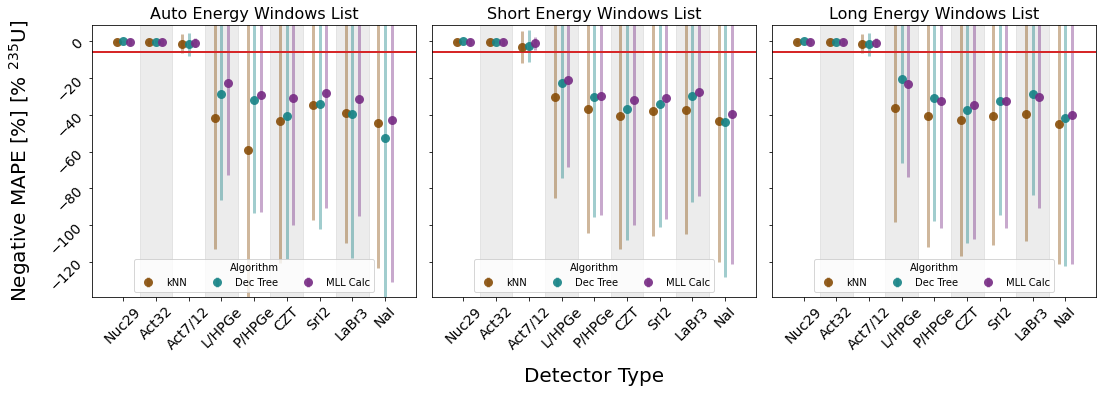

In [9]:
enri_min = [-0.17]
#ig, axs, sv_fig = plot('enrichment', 'U235 Enrichment Prediction, Mean Absolute Error', 'enlist', 'MAE', enri_min)
#axs[0].set_ylim(-2.09, 0.19)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

#enri_min = [-0.5, -0.1]
#fig, axs, sv_fig = plot('enrichment', 'U235 Enrichment Prediction, Median Absolute Error', 'enlist', 'MedAE', enri_min)
#axs[0].set_ylim(-2.09, 0.19)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

enri_min = [-6]
fig, axs, sv_fig = plot('enrichment', '$^{235}$U Enrichment Prediction, Mean Absolute Percentage Error', 'enlist', 'MAPE', enri_min)
axs[0].set_ylim(-139, 9)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

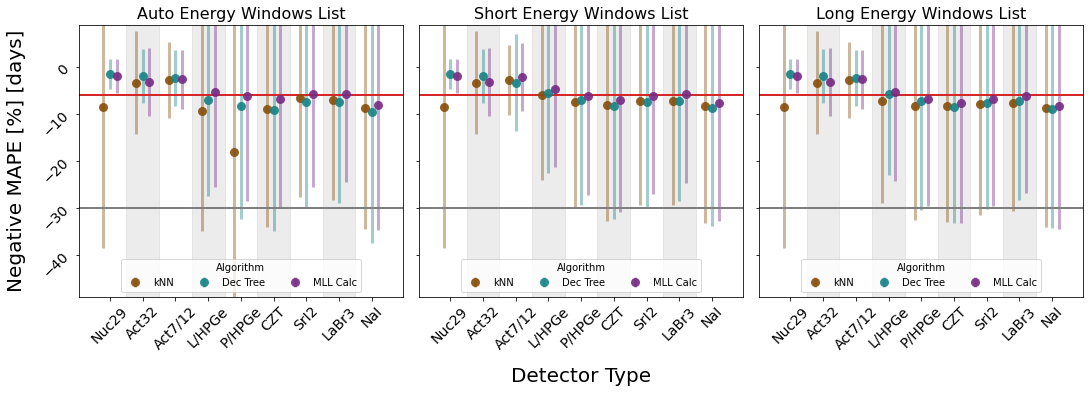

In [13]:
cool_min = [-120, -550]
#fig, axs, sv_fig = plot('cooling', 'Time Since Irradiation Prediction, Mean Absolute Error', 'enlist', 'MAE', cool_min)
#axs[0].set_ylim(-560, 19)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

#cool_min = [-100, -30]
#fig, axs, sv_fig = plot('cooling', 'Time Since Irradiation Prediction, Median Absolute Error', 'enlist', 'MedAE', cool_min)
#axs[0].set_ylim(-340, 19)
#plt.show()
#fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

cool_min = [-6, -30]
fig, axs, sv_fig = plot('cooling', 'Time Since Irradiation Prediction, Mean Absolute Percentage Error', 'enlist', 'MAPE', cool_min)
axs[0].set_ylim(-49, 9)
plt.show()
fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

# Viz for dissertation

In [14]:
def plot_demo():
    
    fig, ax = plt.subplots(figsize=(6,5))
    
    axlbl = 'Negative Error'
    
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    ax.set_ylabel(axlbl, fontsize=20, labelpad=15)
    ax.tick_params(labelsize=14, labelrotation=45)
    hcolor = ['tab:red', 'tab:blue']
    pred_min = [-50]
    for w, pmin in enumerate(pred_min):
        ax.axhline(y=pmin, color=hcolor[w], linestyle='-', linewidth=2)
    ax.set_ylim(-210, 10)
    plt.xticks(range(len(x)), x)
    plt.show()
    
    sv_fig = './plots/exp2_plot_description.png'
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)
    
    return

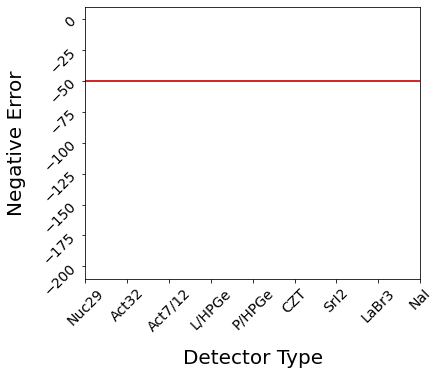

In [15]:
plot_demo()